Initial draft of data specifications for cell classification task.

## Summary

Files must be zip containers (filenames will end in '.zip') and include:
- [X.npy array with dimensions (1, y, x, c); raw data](#load-X-data)
- y.npy array with dimensions (1, y, x, 1); instance labels
- [channels.json](#channel-names)
- [classes/cell_type.json](#cell-type-class-specs)

This notebook will help create each component of the file and save them in the correct output format. This notebook also provides an example of how to extract the file contents after annotation using the python zipfile library.

In [1]:
import copy
from io import BytesIO
import json
import os
import re
import zipfile

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import find_objects

from caliban_toolbox.utils.misc_utils import sorted_nicely

In [2]:
def sanitize(x):
    """Strip out non-alphanumeric characters from a string.
    
    https://stackoverflow.com/a/1276774
    
    returns lowercase version of string to help compare
    possible variations of channel or class names, eg:
        - 'B cell' vs 'Bcell' vs 'b_cell'
    
    Note that this will strip out '+' and '-' characters,
    so if that is the only difference between two class names,
    problems may arise! Use 'pos' or 'neg' when creating names
    for lineage classifications instead.
    """
    return re.sub(r'[^a-zA-Z0-9]', '', x).lower()

In [3]:
def check_tif_ext(filename):
    # dotfile not a legitimate .tif file
    if filename.startswith('.'):
        return False
    if os.path.splitext(filename.lower())[1] in ['.tif', '.tiff']:
        return True
    return False

In [4]:
# example data
DATA_DIR = os.path.abspath('../data/cell_classification_example')

### Starting from predicted classifications
Annotation files for DCL will likely need to be prepared from existing data in a different format.

In [5]:
# load the existing cell classification mapping
example_key = os.path.join(DATA_DIR, 'cell_key.csv')
example_key_df = pd.read_csv(example_key, header=None)

# this corresponds to the pixel-level classification array
# we will need this information to convert from
# the label array to the cell class assignment dictionary we require
example_key_df

,0,1
0,0,Empty
1,1,Other
2,2,Fibroblast
3,3,Endothelial
4,4,Tfh
5,5,Treg
6,6,Plasma
7,7,CD8T
8,8,CD4T
9,9,Bcell


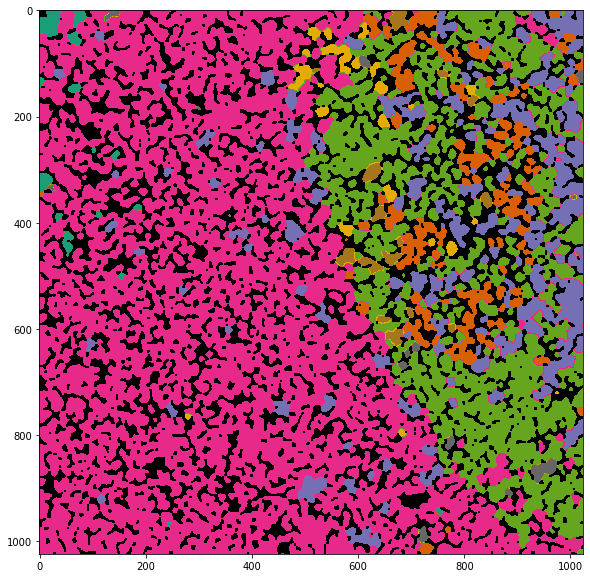

In [6]:
# load and preview the pixel-level classification predictions
example_prediction_path = os.path.join(DATA_DIR, 'Point1', 'Point1_cell_overlay.tiff')
example_prediction_arr = imageio.imread(example_prediction_path)

classes_cmap = plt.get_cmap('Dark2')
classes_cmap.set_bad('black')
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.ma.masked_equal(example_prediction_arr, 0), 
           cmap=classes_cmap)

In [7]:
# add dimensions to array to match expected shape for instance labels later on
y_classes = example_prediction_arr.astype(np.uint16)  # convert from int16
y_classes = np.expand_dims(y_classes, axis=0)  # add trivial z dim
y_classes = np.expand_dims(y_classes, axis=-1)  # add trivial "channel" dim

### Load and prepare the instance masks

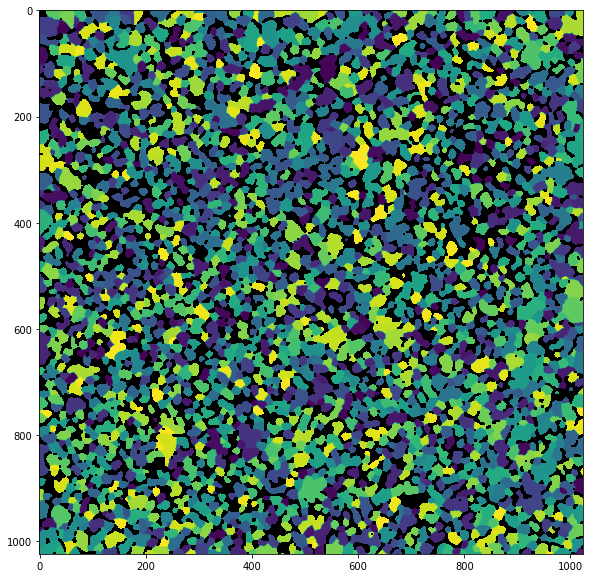

In [8]:
# load and preview the pixel-level instance labels
example_labels_path = os.path.join(DATA_DIR, 'Point1', 'Point1_segmentation_labels.tiff')
example_labels_arr = imageio.imread(example_labels_path)

labels_cmap = plt.get_cmap('viridis')
labels_cmap.set_bad('black')
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.ma.masked_equal(example_labels_arr, 0), 
           cmap=labels_cmap)

In [9]:
def label_order(y_stack):
    # flattened (1D) array with all zeros removed, but repeated label values
    flat_labels = y_stack.ravel()[np.flatnonzero(y_stack)]
    
    # get the index of each unique value, sorted in order of index (not value); indexes the 1D array
    indices = np.unique(np.unique(flat_labels, return_index=True)[1])

    # gives us a 1D array that contains one entry per non-zero label
    # in order of appearance of the labels in the array
    labels = flat_labels[indices]
    
    return labels

def deep_relabel(y_stack):
    objects = find_objects(y_stack)

    relabeled_y = np.zeros(y_stack.shape, dtype=y_stack.dtype)
    original_labels = label_order(y_stack)
    
    for new_label, old_label in enumerate(original_labels, 1):
        relabeled_y[objects[old_label - 1]] = np.where(y_stack[objects[old_label - 1]] == old_label, 
                                                       new_label, 
                                                       relabeled_y[objects[old_label - 1]])
            
    return relabeled_y

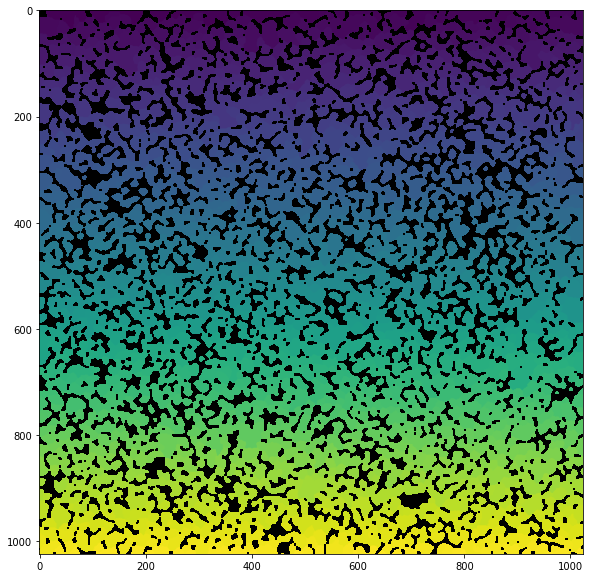

In [10]:
# relabel the instance masks so labels appear in a consistent order
example_labels_arr = deep_relabel(example_labels_arr)

# the colors of adjacent instance labels will be harder to distinguish
# but that doesn't matter for this labeling task
labels_cmap = plt.get_cmap('viridis')
labels_cmap.set_bad('black')
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.ma.masked_equal(example_labels_arr, 0), 
           cmap=labels_cmap)

In [11]:
# add dimensions to instance labels array to create expected shape, store as y
y = example_labels_arr.astype(np.uint16)  # convert from int16
y = np.expand_dims(y, axis=0)  # add trivial z dim
y = np.expand_dims(y, axis=-1)  # add trivial "channel" dim

### Channel names <a name="channel-names"></a>
Information about channel names is stored at the top level of the zipfile in `channels.json`.

This file contains a dictionary mapping each channel index to its name (usually the name of the marker used). This is stored as a dictionary, rather than a list, to make it easier to view the index of each channel name if needed.

This file is referenced for general display purposes, as well as to determine the channel indices used for designated channel "preset" combinations.

As a python dict:
```python
{
    0: 'Au',
    1: 'Background',
    2: 'C',
    3: 'Ca',
    4: 'CC3'
}
```

As JSON:
```json
{
  "0": "Au",
  "1": "Background",
  "2": "C",
  "3": "Ca",
  "4": "CC3"
}
```

### Load channels to make the array and channel name info<a name="load-X-data"></a>
The provided example data has one .tif for each channel. This section loads images in this format into a numpy array (`X.npy`) and creates the mapping of channel names to indices.

In [12]:
images_folder = os.path.join(DATA_DIR, 'Point1', 'TIFs')

# get list of files
file_list = sorted_nicely(os.listdir(images_folder))

# get list of .tif images (no dotfiles either)
img_name_list = [f for f in file_list if check_tif_ext(f)]

In [13]:
# load images and store in a list
img_list = [imageio.imread(os.path.join(images_folder, i)) for i in img_name_list]

# stack the images along channel axis
X = np.stack(img_list, axis=-1)
# array also needs a trivial Z or T dimension
X = np.expand_dims(X, axis=0)

# array should now have shape of (1, height, width, num_channels)
print(X.shape, X.dtype)

(1, 1024, 1024, 45) uint16


In [14]:
# create dictionary with channel names and indices
channel_names = {i: os.path.splitext(name)[0] for i, name in enumerate(img_name_list)}

### Cell type classifications<a name="cell-type-class-specs"></a>
AKA cell developmental lineages. This is named `cell_type.json` to avoid confusion with the `lineage.json` file that contains annotations of cell divisions in files for our live cell tracking project. This file is stored within the `classes` folder of the zip container.

This file contains a mapping of class names to integers (`'cell_types'` entry), as well as the class values assigned to each label in the file (`'assignments'` entry). The assignments for each instance label are grouped on a frame-by-frame basis, although these files only contain one frame's worth of assignments (frame `0`). 

We've pre-populated values for anticipated classes, like the `'CD4T'` class below. Because the classes are defined and stored alongside the assigned values, these initial class definitions and groupings can be safely added to or modified.

For each class specified in this file, helpful channels can also be defined, which will be displayed in the Label app as "preset" combinations to help annotation.

We provide a starting point for each tissue that looks like this (example from `HIV` tissue definition):
```python
{
    'cell_types': {
        # class_id: class_information
        0: {
            'name': 'unassigned',
            'channel_names': None,
            'channels': None
        },
        1: {
            'name': 'CD4T', 
            'channel_names': ['CD45', 'CD3', 'CD4']
        },
        2: {
            'name': 'CD8T', 
            'channel_names': ['CD45', 'CD3', 'CD8']
        },
        3: {
            'name': 'B cell', 
            'channel_names': ['CD45', 'CD20', 'CD21']
        },
        # several more entries
    }
}
```
When creating an annotation file, these entries will be expanded to include the channel indices specific to that file. The mapping of each instance label to its semantic classification will also be generated and included.

As a python dict, this looks like:
```python
    {        
        'cell_types': {
            # class_id: class_information
            0: {
                'name': 'unassigned',
                'channel_names': None,
                'channels': None
            },
            1: {
                'name': 'CD4T', 
                'channel_names': ['CD45', 'CD3', 'CD4'],
                'channels': [16, 13, 15]  # whichever channel indices apply to the file
            },
            2: {
                'name': 'CD8T', 
                'channel_names': ['CD45', 'CD3', 'CD8'],
                'channels': [16, 13, 20]
            },
            3: {
                'name': 'B cell', 
                'channel_names': ['CD45', 'CD20', 'CD21'],
                'channels': [16, 9, 12]
            },
            # several more entries
        },
        'assignments': {
            # frame number: label assignments in that frame
            0: {
                # label_id: class_id
                # no entry for "label" 0
                1: 5,  # class 5
                2: 1,  # class 1 = CD4T class in this example
                # okay if labels are not sequential, but we try to avoid this
                4: 0,  # unassigned class
            }
        }
    }
```

As JSON, this looks like:
```json
{
  "cell_types": {
    "0": {
      "name": "unassigned",
      "channel_names": null,
      "channels": null
    },
    "1": {
      "name": "CD4T",
      "channel_names": [
        "CD45",
        "CD3",
        "CD4"
      ],
      "channels": [
        16,
        13,
        15
      ]
    },
    "2": {
      "name": "CD8T",
      "channel_names": [
        "CD45",
        "CD3",
        "CD8"
      ],
      "channels": [
        16,
        13,
        20
      ]
    },
    "3": {
      "name": "B cell",
      "channel_names": [
        "CD45",
        "CD20",
        "CD21"
      ],
      "channels": [
        16,
        9,
        12
      ]
    }
  },
  "assignments": {
    "0": {
      "1": 5,
      "2": 1,
      "4": 0
    }
  }
}

```

### Pre-defined sets of markers
These can be reordered to make the review workflow smoother: because each class id number is paired with the name of the class, this will not lose information. Note that id `0` is a special case--this is the catch-all class for unassigned labels previously indicated by a pixel-level label of `1`.

The subclass `HIV`, below, is defined with semantic classes that correspond to the "gold standard phenotypes" spreadsheet.

Notes on defining or modifying the semantic label definitions:

##### `'channel_names'` attribute
- up to 6 channel names are allowed for "preset" generation
- the order the names are listed in will (likely) determine what color that channel is shown with in the preset
  - in the future, this will be customizable within the Label interface
  - for now, channels will be shown with RGBCMY color ordering
  - for example, 'CD45' is the first channel listed for each cell type it appears in; it will always be displayed with red
- there will also be an option to pick and choose channels without a preset
- channel colors are customizable from that interface
- presets do not have to exhaustively cover channel combinations you may need to view; just the most common combination for judging each cell type, for your convenience
- the channel names do not strictly have to be present in the file you're working with
- channel names will be displayed in the Label interface, you will not need to remember the mapping of colors to channel names

##### reordering the semantic label ids
We recommend arranging the ids in the order you want to review the classifications. It will be easiest to move between adjacent classes and/or toggle between adjacent presets. Eg, if T cells are commonly misclassified as each other, assigning the CD4T, CD8T, T_reg, and Tfh classes to semantic labels 1-4 may help to switch back and forth between viewing their channel presets and adjusting classifications.

The class ids assigned here do NOT need to match the provided `cell_key.csv` file. The `TissueCellTypes` class will handle re-mapping predictions to our format appropriately. We will also provide a way to convert the DCL-corrected annotations back to pixel-level arrays with the `cell_key.csv` or other provided label key.

In [15]:
class TissueCellTypes:
    """Base class for storing and converting file-specific semantic judgments.
    """
    # for each semantic class, define 'name' and 'channel_names'
    # 'channels' is shown for clarity but does not need to be defined
    unassigned = {
        'name': 'other',  # name of the class
        'channel_names': None,  # names of channels to show in preset, if available
        'channels': None  # auto-generated to match channel_names
    }

    cell_types = {
        0: unassigned
    }

    def __init__(self, instance_labels, channels_map=None):
        self.y = instance_labels
        self.channels_map = channels_map
        if self.channels_map is not None:
            self.find_channel_indices()
        self.assignments = None
        self.all_semantic_info = None
    
    def map_assignments(self, semantic_array, cell_key):
        """Format the lineage assignments
        
        cell_key: pandas dataframe read from csv,
            like the one provided in example data;
            expects column with pixel label values
            corresponding to the class name in the other column
        semantic_array: labeled array where each pixel value
            designates the assigned class; these assignments
            will be consolidated into a dictionary for ease of use
        """
        pixel_mapping = self._match_semantic_array(semantic_array)
        classification_mapping = self._match_cell_key(cell_key)
        self.assignments = self._apply_maps(pixel_mapping, classification_mapping)
        self.all_semantic_info = {
            'cell_types': self.cell_types,
            'assignments': self.assignments
        }
               
    def _match_semantic_array(self, semantic_array):
        """Get the semantic id for each instance label value.
        """
        pixel_mapping = {}
        
        # allows multiple frames, although we don't need that yet
        for frame in range(self.y.shape[0]):
            pixel_mapping[frame] = {}
            
            # expect these to be in shape (frames, y, x, 1)
            y_frame = y[frame, :, :, 0]
            y_class_frame = semantic_array[frame, :, :, 0]
            
            # instance label ids present in this frame
            labels = np.unique(y_frame)[np.nonzero(np.unique(y_frame))]
            for i in labels:
                semantic_id_choices = semantic_array[self.y == i]
                # ideally, should only be one semantic id to "choose" from
                # but just in case, get the one with the highest count
                choices, count = np.unique(semantic_id_choices, return_counts=True)
                # get index of highest count so we can choose that semantic label
                best_choice = choices[np.argmax(count)]
                
                # store the semantic id identified for this instance label
                pixel_mapping[frame][i] = best_choice
                
        return pixel_mapping
            
    def _match_cell_key(self, cell_key):
        classification_mapping = {}
        for row in cell_key.iterrows():
            old_value = row[0]
            class_name = row[1][1]  # row[1] is a pd.Series, get the value from it
            
            # default value if match not found
            classification_mapping[old_value] = None

            for k, v in self.cell_types.items():
                if sanitize(v['name']) == sanitize(class_name):
                    # match class name to the class names we have defined
                    classification_mapping[old_value] = k
                    break
                
            # temporary, for troubleshooting class name mismatches
#             if classification_mapping[old_value] is None:
#                 print(class_name)

        return classification_mapping

    def _apply_maps(self, pixel_mapping, classification_mapping):
        assignments = {}
        for frame, instance_map in pixel_mapping.items():
            assignments[frame] = {}
            
            for instance_label, old_class_id in instance_map.items():
                new_class_id = classification_mapping[old_class_id]
                # json will struggle with uint instance_label key
                assignments[frame][int(instance_label)] = new_class_id
                
        return assignments
    
    def find_channel_indices(self):
        # modify the channel indices in this object, not for whole class
        self.cell_types = copy.deepcopy(self.cell_types)
        for lineage in self.cell_types.values():
            preset_names = lineage.get('channel_names', None)
            if preset_names is not None:
                indices = self._match_channel_index(preset_names)
                lineage['channels'] = indices
            else:
                lineage['channels'] = None
                
    def _match_channel_index(self, preset_names):
        # not the prettiest list comprehension, sorry
        indices = [k for p in preset_names \
                     for k, v in self.channels_map.items() \
                     if sanitize(v) == sanitize(p)]
        if indices == []:
            return None  # no preset
        return indices
    
    def make_zipfile(self, output_path, X):
        with zipfile.ZipFile(output_path, 'w', 
                             compression=zipfile.ZIP_DEFLATED) as container:
            
            with BytesIO() as X_bytes:                
                with container.open('X.npy', 'w') as zip_X:
                    np.save(X_bytes, X)
                    X_bytes.seek(0)
                    zip_X.write(X_bytes.getvalue())
                    
            with BytesIO() as y_bytes:
                with container.open('y.npy', 'w') as zip_y:
                    np.save(y_bytes, self.y)
                    y_bytes.seek(0)
                    zip_y.write(y_bytes.getvalue())
                    
            container.writestr('classes/cell_type.json', json.dumps(self.all_semantic_info))
            container.writestr('channels.json', json.dumps(self.channels_map))    

In [16]:
class HIV(TissueCellTypes):
    cd4t = {
        'name': 'CD4T',
        'channel_names': ['CD45', 'CD3', 'CD4']
    }
    cd8t = {
        'name': 'CD8T',
        'channel_names': ['CD45', 'CD3', 'CD8']
    }
    b_cell = {
        'name': 'B cell',
        'channel_names': ['CD45', 'CD20', 'CD21']
    }
    fdc = {
        'name': 'FDC',
        'channel_names': ['CD45', 'CD21']
    }
    endothelial = {
        'name': 'Endothelial',
        'channel_names': ['CD31']
    }
    fibroblast = {
        'name': 'Fibroblast',
        'channel_names': ['SMA']
    }
    other_immune = {
        'name': 'Other immune',
        'channel_names': ['CD45']
    }
    cd11c_pos_dcs = {
        'name': 'CD11c+ DC',
        'channel_names': ['CD45', 'HLADR', 'CD11c']
    }
    cd209_pos_dcs = {
        'name': 'CD209+ DC',
        'channel_names': ['CD45', 'HLADR', 'CD11c', 'CD209']
    }
    cd14_pos_mono_mac = {
        'name': 'CD14+ mac',
        'channel_names': ['CD45', 'CD14']
    }
    cd68_pos_mac = {
        'name': 'CD68+ mac',
        'channel_names': ['CD45', 'CD68']
    }
    neutrophil = {
        'name': 'Neutrophil',
        'channel_names': ['MPO']
    }
    treg = {
        'name': 'T_reg',
        'channel_names': ['CD45', 'CD3', 'Foxp3']
    }
    tfh = {
        'name': 'Tfh',
        'channel_names': ['CD45', 'CD3', 'CD4', 'PD1']
    }
    plasma = {
        'name': 'Plasma',
        'channel_names': ['CD138']
    }
    cd209_pos_cd206_pos_mac = {
        'name': 'CD209+ CD206+ mac',
        'channel_names': ['CD45', 'CD68', 'CD163', 'CD209', 'CD206']
    }

    cell_types = {
        0: TissueCellTypes.unassigned,
        1: cd4t,
        2: cd8t,
        3: b_cell,
        4: fdc,
        5: endothelial,
        6: fibroblast,
        7: other_immune,
        8: cd11c_pos_dcs,
        9: cd209_pos_dcs,
        10: cd14_pos_mono_mac,
        11: cd68_pos_mac,
        12: neutrophil,
        13: treg,
        14: tfh,
        15: plasma,
        16: cd209_pos_cd206_pos_mac
    }
        

In [17]:
Point1 = HIV(instance_labels=y, channels_map=channel_names)

In [18]:
# generate the indices for channel presets in this file
# find_channel_indices happens automatically if intialized w/ channel names info

# this information now contains a 'channels' entry for each semantic class
Point1.cell_types

{0: {'name': 'other', 'channel_names': None, 'channels': None},
 1: {'name': 'CD4T',
  'channel_names': ['CD45', 'CD3', 'CD4'],
  'channels': [16, 13, 15]},
 2: {'name': 'CD8T',
  'channel_names': ['CD45', 'CD3', 'CD8'],
  'channels': [16, 13, 20]},
 3: {'name': 'B cell',
  'channel_names': ['CD45', 'CD20', 'CD21'],
  'channels': [16, 9, 12]},
 4: {'name': 'FDC', 'channel_names': ['CD45', 'CD21'], 'channels': [16, 12]},
 5: {'name': 'Endothelial', 'channel_names': ['CD31'], 'channels': [14]},
 6: {'name': 'Fibroblast', 'channel_names': ['SMA'], 'channels': [37]},
 7: {'name': 'Other immune', 'channel_names': ['CD45'], 'channels': [16]},
 8: {'name': 'CD11c+ DC',
  'channel_names': ['CD45', 'HLADR', 'CD11c'],
  'channels': [16, 4]},
 9: {'name': 'CD209+ DC',
  'channel_names': ['CD45', 'HLADR', 'CD11c', 'CD209'],
  'channels': [16, 4, 11]},
 10: {'name': 'CD14+ mac',
  'channel_names': ['CD45', 'CD14'],
  'channels': [16, 6]},
 11: {'name': 'CD68+ mac',
  'channel_names': ['CD45', 'CD68

In [19]:
# compare to the parent class cell_types attribute 
# which still does not contain channel indices
HIV.cell_types

{0: {'name': 'other', 'channel_names': None, 'channels': None},
 1: {'name': 'CD4T', 'channel_names': ['CD45', 'CD3', 'CD4']},
 2: {'name': 'CD8T', 'channel_names': ['CD45', 'CD3', 'CD8']},
 3: {'name': 'B cell', 'channel_names': ['CD45', 'CD20', 'CD21']},
 4: {'name': 'FDC', 'channel_names': ['CD45', 'CD21']},
 5: {'name': 'Endothelial', 'channel_names': ['CD31']},
 6: {'name': 'Fibroblast', 'channel_names': ['SMA']},
 7: {'name': 'Other immune', 'channel_names': ['CD45']},
 8: {'name': 'CD11c+ DC', 'channel_names': ['CD45', 'HLADR', 'CD11c']},
 9: {'name': 'CD209+ DC',
  'channel_names': ['CD45', 'HLADR', 'CD11c', 'CD209']},
 10: {'name': 'CD14+ mac', 'channel_names': ['CD45', 'CD14']},
 11: {'name': 'CD68+ mac', 'channel_names': ['CD45', 'CD68']},
 12: {'name': 'Neutrophil', 'channel_names': ['MPO']},
 13: {'name': 'T_reg', 'channel_names': ['CD45', 'CD3', 'Foxp3']},
 14: {'name': 'Tfh', 'channel_names': ['CD45', 'CD3', 'CD4', 'PD1']},
 15: {'name': 'Plasma', 'channel_names': ['CD13

In [20]:
Point1.map_assignments(semantic_array=y_classes, cell_key=example_key_df)

In [21]:
Point1.make_zipfile(os.path.join(DATA_DIR, 'Point1.zip'), X)

In [ ]:
# Point1.all_semantic_info